<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/RNN_Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D,\
LSTM,GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 26.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2023-11-23 06:43:12--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2023-11-23 06:43:12 (23.5 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [5]:
df = pd.read_csv("airline_passengers.csv",index_col = 'Month',parse_dates = True)

In [6]:
df['LogPassengers'] = np.log(df['Passengers'])

In [7]:
NTest = 12
train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [8]:
#Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

In [9]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [10]:
#Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t : t + T]
  X.append(x)
  y = series[t + T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y)
N = len(X)

print("X.shape: ",X.shape," Y shape: ",Y.shape)

X.shape:  (133, 10, 1)  Y shape:  (133,)


In [11]:
XTrain,YTrain = X[:-NTest],Y[:-NTest]
XTest,YTest = X[-NTest:],Y[-NTest:]

In [12]:
#RNN
i = Input(shape = (T,1))
x = LSTM(24)(i)
x = Dense(1)(x)

model = Model(i,x)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2521 (9.85 KB)
Trainable params: 2521 (9.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


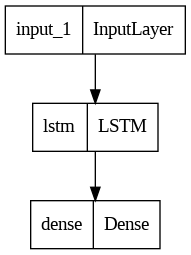

In [14]:
tf.keras.utils.plot_model(model)

In [15]:
r = model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [16]:
r = model.fit(
    XTrain,
    YTrain,
    epochs = 100,
    validation_data = (XTest,YTest)
)

Epoch 1/100
4/4 [==============================] - 4s 212ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 2/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 4/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 6/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 7/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 8/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0098 - val_loss: 0.0093
Epoch 9/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 10/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 11/100
4/4 [

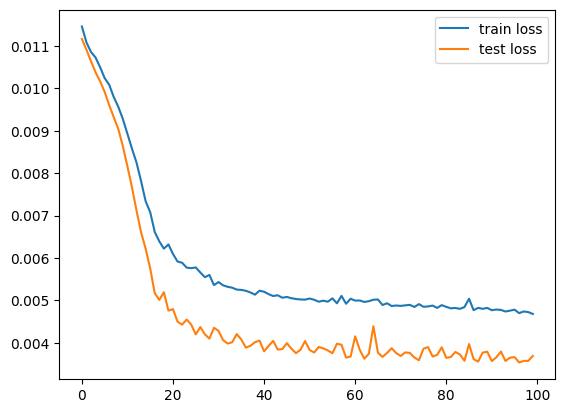

In [17]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

In [18]:
#First T+1 values are not predictable
train_idx[:T+1] = False

In [19]:
PTrain = model.predict(XTrain).flatten()
PTest = model.predict(XTest).flatten()

1/1 [==============================] - 0s 55ms/step


In [20]:
#Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [34]:
#Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [22]:
#1-step forecast
df.loc[train_idx,'1step_train'] = prev[train_idx] + PTrain
df.loc[test_idx,'1step_test'] = prev[test_idx] + PTest

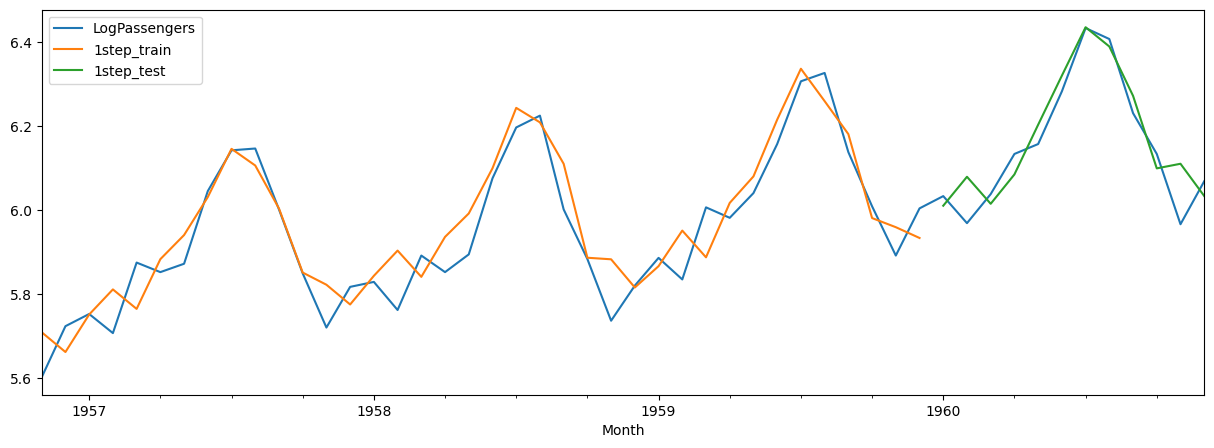

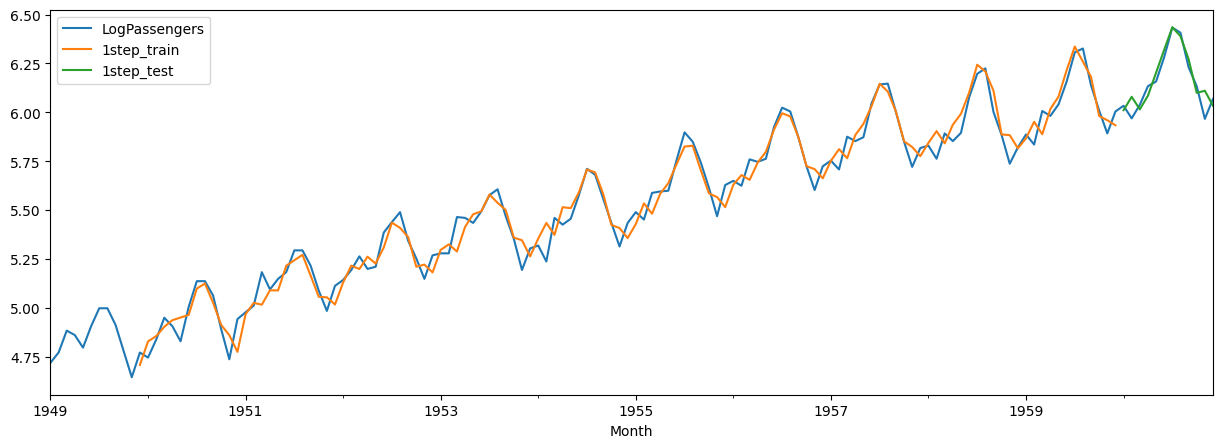

In [25]:
#plot 1-step forecast
cols = [
    'LogPassengers',
    '1step_train',
    '1step_test'
]

df.iloc[-50:][cols].plot(figsize = (15,5))
df[cols].plot(figsize = (15,5));

In [33]:
#multi step predictions
multistep_predictions = []

#first test input
x_last = XTest[0]

for t in range(len(multistep_predictions) < NTest):
    p = model.predict(x_last.reshape(1,-1,1))[0]

    #Update the predictions list
    multistep_predictions.append(p)

    #Update the new input
    x_last = XTest[0] = np.roll(x_last,-1)
    x_last[-1] = p

1/1 [==============================] - 0s 22ms/step


In [35]:
df.loc[test_idx,'multistep'] = last_train + np.cumsum(multistep_predictions)

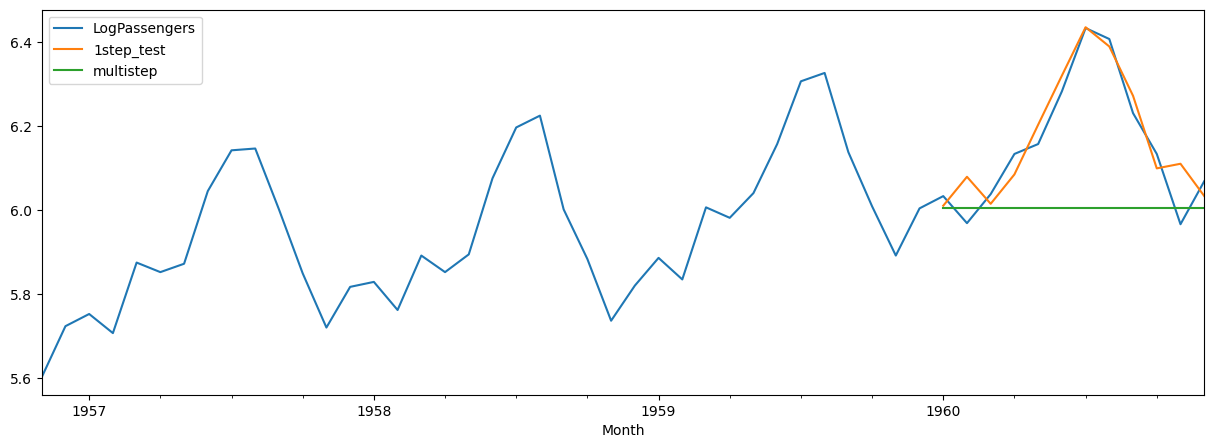

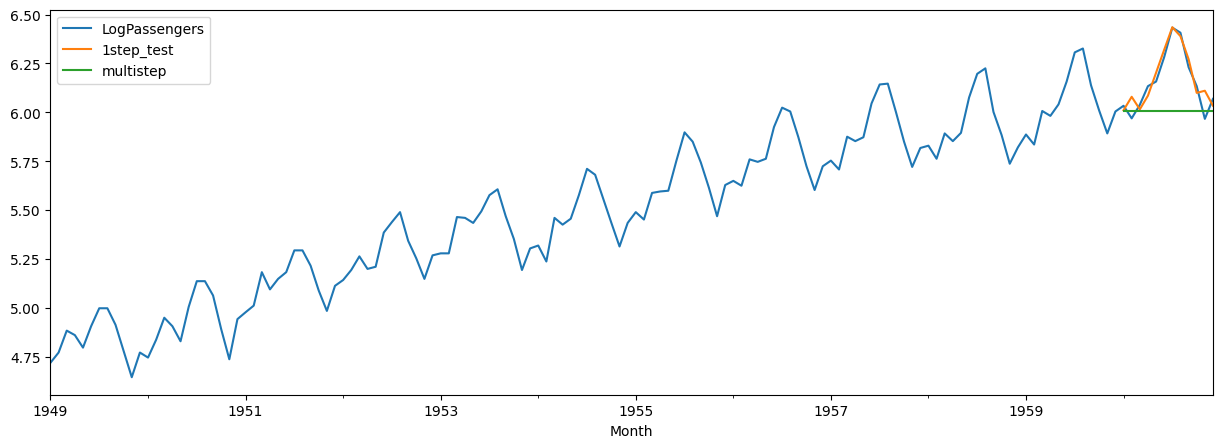

In [36]:
cols = [
    'LogPassengers',
    '1step_test',
    'multistep'
]
df.iloc[-50:][cols].plot(figsize = (15,5))
df[cols].plot(figsize = (15,5));

In [38]:
#Make the multi-output supervised dataset
Tx = T
Ty = NTest
X = []
Y = []

for t in range(len(series) - Tx - Ty):
  x = series[t : t + Tx]
  X.append(x)
  y = series[t + Tx : t + Tx + Ty]
  Y.append(y)

X = np.array(X).reshape(-1,Tx,1)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)

print("X shape: ",X.shape, " Y shape: ",Y.shape)

X shape:  (121, 10, 1)  Y shape:  (121, 12)


In [43]:
XTrain_m,YTrain_m = X[:-1],Y[:-1]
XTest_m,YTest_m = X[-1:],Y[-1:]

In [40]:
#RNN
i = Input(shape = (Tx,1))
x = LSTM(24,return_sequences = True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)

model = Model(i,x)

In [41]:
check_point = ModelCheckpoint(
    'best_model',monitor = 'val_loss',save_best_model = True
)

In [48]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [ ]:
r = model.fit(
    XTrain_m,
    YTrain_m,
    epochs = 300,
    validation_data = (XTest_m,YTest_m),
    callbacks = [check_point]
)

Epoch 1/300
4/4 [==============================] - 5s 2s/step - loss: 0.0026 - val_loss: 0.0039
Epoch 2/300
4/4 [==============================] - 4s 1s/step - loss: 0.0027 - val_loss: 0.0040
Epoch 3/300
4/4 [==============================] - 4s 1s/step - loss: 0.0026 - val_loss: 0.0037
Epoch 4/300
4/4 [==============================] - 9s 3s/step - loss: 0.0026 - val_loss: 0.0038
Epoch 5/300
4/4 [==============================] - 10s 3s/step - loss: 0.0026 - val_loss: 0.0038
Epoch 6/300
4/4 [==============================] - 7s 2s/step - loss: 0.0026 - val_loss: 0.0038
Epoch 7/300
4/4 [==============================] - 4s 1s/step - loss: 0.0026 - val_loss: 0.0037
Epoch 8/300
4/4 [==============================] - 5s 2s/step - loss: 0.0026 - val_loss: 0.0039
Epoch 9/300
4/4 [==============================] - 4s 1s/step - loss: 0.0026 - val_loss: 0.0039
Epoch 10/300
4/4 [==============================] - 4s 1s/step - loss: 0.0026 - val_loss: 0.0035
Epoch 11/300
4/4 [====================

In [ ]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

In [ ]:
#Load best model
best_model = tf.keras.models.load_model('best_model')

In [ ]:
PTrain = best_model.predict(XTrain_m)
PTest = best_model.predict(XTest_m)

In [ ]:
PTrain.shape,PTest.shape

In [ ]:
#Make sure the data is in the right shape
PTrain = PTrain[:,0]
PTest = PTest[0]

In [ ]:
#Save multi-output forecast
df.loc[test_idx,'multioutput'] = last_train + \
np.cumsum(PTest)

In [ ]:
#Plot all forecast
cols = [
    'LogPassengers',
    'multistep',
    'multioutput',
    '1step_test'
]
df.iloc[-50:][cols].plot(figsize = (15,5))
df[cols].plot(figsize = (15,5));